In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from PIL import Image

import random
import time

try:
    from torchsummary import summary
except:
    !pip install torch_summary
    from torchsummary import summary
    
import os
import shutil
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [3]:
!git clone https://github.com/Almotasembelah/Age_Gender_Classification.git

Cloning into 'Age_Gender_Classification'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 116 (delta 27), reused 107 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 21.54 KiB | 4.31 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [4]:
import shutil

shutil.move('Age_Gender_Classification/models', 'models')
shutil.move('Age_Gender_Classification/utils', 'utils')
! rm -r Age_Gender_Classification

In [5]:
# import importlib
# import models, utils
# importlib.reload(utils)
# importlib.reload(models)
from utils.manager import *
from models.models import *
from models.cnn_model import *
from utils.data import *

In [6]:
root = '/kaggle/input/fairface/FairFace/'
train_csv = root + 'train_labels.csv'
val_csv = root + 'val_labels.csv'
train_labels = pd.read_csv(train_csv)
val_labels = pd.read_csv(val_csv)

In [7]:
# Creating weights for age and race classes for the loss function
age_counts = train_labels['age'].value_counts()
race_counts = train_labels['race'].value_counts()

# Total number of samples
total_samples = sum(age_counts.values)
# Calculate weights
age_weights = {cls: total_samples / count for cls, count in zip(age_counts.index.values, age_counts.values)}
# Normalize weights
normalized_age_weights = {cls: weight / sum(age_weights.values()) for cls, weight in age_weights.items()}

# Total number of samples
total_samples = sum(race_counts.values)
# Calculate weights
race_weights = {cls: total_samples / count for cls, count in zip(race_counts.index.values, race_counts.values)}
# Normalize weights
normalized_race_weights = {cls: weight / sum(race_weights.values()) for cls, weight in race_weights.items()}
age_list = ['0-2','3-9','10-19','20-29', '30-39', '40-49','50-59','60-69','more than 70']
normalized_age_weights = {key: normalized_age_weights[key] for key in age_list}
print("Normalized Age Weights:\n", normalized_age_weights)
print("Normalized Race Weights:\n", normalized_race_weights)

Normalized Age Weights:
 {'0-2': 0.21009481648902822, '3-9': 0.03617312751233076, '10-19': 0.041358882912044224, '20-29': 0.014707786200028852, '30-39': 0.019557917462251353, '40-49': 0.035041875572257866, '50-59': 0.060451173915918206, '60-69': 0.13547675823977637, 'more than 70': 0.4471376616963641}
Normalized Race Weights:
 {'White': 0.10418437808097465, 'Latino_Hispanic': 0.1288138861782201, 'Indian': 0.13977232052473967, 'East Asian': 0.14013634056679972, 'Black': 0.14075494290397025, 'Southeast Asian': 0.15950488342234997, 'Middle Eastern': 0.18683324832294576}


# Load the Data


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
transform = transforms.Compose([ 
                                transforms.Resize(224),
                                transforms.ToTensor(),
                                # normalizer,
                              transforms.RandomHorizontalFlip(0.5),
                               transforms.RandomAutocontrast(0.5),
                               transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
                               transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1)
                               ])
val_transform = transforms.Compose([ 
                                transforms.Resize(224),
                                transforms.ToTensor(),
                                # normalizer,
                                
                               ])

# Preparing Data for efficientNet 
train_dataset = FairFaceDataset(train_labels, transform=transform)
val_dataset = FairFaceDataset(val_labels, transform=val_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, drop_last=True)

In [14]:
age_weights = torch.tensor(list(normalized_age_weights.values()), dtype=torch.float, device=device)
race_weights = torch.tensor(list(normalized_race_weights.values()), dtype=torch.float, device=device)

gender_loss_fn = nn.BCELoss(reduction='mean')
race_loss_fn = nn.CrossEntropyLoss(reduction='mean', weight=race_weights)
age_loss_fn = nn.CrossEntropyLoss(reduction='mean', weight=age_weights)

In [15]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
gen_loss_fn_nl = nn.BCEWithLogitsLoss()
mlt_model = EfficientNetB0(1024, Task.AGE, freeze=False)
mlt_model.model.classifier.fc_age = nn.Sequential(
                                            nn.Linear(1280, 1024, bias=False),
                                            nn.BatchNorm1d(1024),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout1d(0.2),
                                            nn.Linear(1024, 512, bias=False),
                                            nn.BatchNorm1d(512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout1d(0.2),
                                            nn.Linear(512, 17)
                                            )
mlt_optimizer = optim.Adam(lr=0.001, params = mlt_model.parameters())
mlt_mm = ModelManagerV2(mlt_model, mlt_optimizer, [gen_loss_fn_nl, age_loss_fn, race_loss_fn])
mlt_mm.set_dataloaders(train_loader, val_loader)
mlt_scheduler = ReduceLROnPlateau(mlt_optimizer, patience=5, threshold=0.001)
mlt_mm.set_lr_scheduler(mlt_scheduler)
mlt_mm.set_tasks_names('Gen', 'Age', 'Race')

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 204MB/s]


In [18]:
# summary(mlt_model.to(device), (3, 224, 224))

In [16]:
mlt_mm.train(5, display_table=True) # with 3 Linear layers

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,1,3.7353,2.6192,0.4861,0.2938,1.6947,1.2060,1.5546,1.1194,81.32%,84.51%,38.19%,46.22%,50.52%,55.95%,0.001
1,2,3.3512,2.4884,0.4167,0.2465,1.5418,1.1875,1.3927,1.0545,87.85%,89.11%,45.52%,40.84%,60.56%,61.91%,0.001
2,3,3.2700,2.4563,0.4049,0.2436,1.5118,1.2038,1.3534,1.0089,89.32%,89.05%,47.98%,40.63%,63.28%,62.64%,0.001
3,4,3.1930,2.3151,0.3925,0.2233,1.4813,1.1102,1.3192,0.9816,90.06%,90.62%,49.28%,52.70%,65.31%,63.99%,0.001
4,5,3.1369,2.2715,0.3843,0.2054,1.4558,1.1061,1.2969,0.9601,90.73%,90.80%,50.80%,49.53%,66.66%,63.54%,0.001


In [24]:
# mlt_mm.load_checkpoint('/kaggle/input/bestv1/pytorch/default/1/best (1)')

In [18]:
mlt_mm.train(5, display_table=True)

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,6,3.0893,2.1947,0.3745,0.2123,1.4410,1.0544,1.2738,0.9279,91.59%,89.81%,51.71%,49.95%,67.89%,65.07%,0.001
1,7,3.0322,2.1776,0.3679,0.1995,1.4107,1.0613,1.2536,0.9167,91.84%,92.20%,52.83%,49.22%,68.95%,66.37%,0.001
2,8,3.0046,2.2300,0.3644,0.1979,1.3978,1.1192,1.2425,0.9129,92.25%,91.25%,53.49%,45.34%,69.84%,66.13%,0.001
3,9,2.9625,2.1442,0.3606,0.1937,1.3795,1.0513,1.2223,0.8992,92.45%,92.04%,54.20%,54.62%,70.79%,66.64%,0.001
4,10,2.9249,2.1351,0.3555,0.1832,1.3600,1.0530,1.2094,0.8990,92.81%,92.06%,54.64%,51.40%,71.22%,65.49%,0.001


In [19]:
mlt_mm.train(5, display_table=True)

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,11,2.9605,2.1398,0.3592,0.1910,1.3794,1.0725,1.2218,0.8763,92.85%,92.36%,54.75%,51.95%,71.41%,68.11%,0.001
1,12,2.9422,2.0912,0.3566,0.1850,1.3754,1.0240,1.2102,0.8822,92.94%,93.03%,55.17%,53.80%,71.98%,67.92%,0.001
2,13,2.9264,2.0874,0.3556,0.1852,1.3628,1.0418,1.2079,0.8605,93.20%,92.75%,55.71%,51.09%,72.28%,68.52%,0.001
3,14,2.8803,2.0739,0.3505,0.1783,1.3381,1.0387,1.1916,0.8569,93.51%,92.07%,56.25%,53.03%,73.04%,67.84%,0.001
4,15,2.8715,2.0678,0.3490,0.1815,1.3352,1.0412,1.1874,0.8451,93.74%,91.07%,56.54%,53.64%,73.36%,69.43%,0.001


In [20]:
mlt_mm.train(5, display_table=True)

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,16,2.8398,2.0535,0.3446,0.1759,1.3221,1.0336,1.1731,0.8439,93.76%,92.61%,57.08%,54.50%,74.13%,69.10%,0.001
1,17,2.8275,2.0989,0.3443,0.1811,1.3149,1.0715,1.1683,0.8463,93.97%,91.68%,57.48%,51.33%,74.40%,68.30%,0.001
2,18,2.8115,2.0513,0.3423,0.1725,1.3083,1.0465,1.1609,0.8323,94.29%,92.06%,57.62%,54.29%,75.04%,69.00%,0.001
3,19,2.7968,2.0670,0.3409,0.1780,1.2978,1.0430,1.1582,0.8461,94.34%,92.86%,58.11%,53.17%,75.15%,68.62%,0.001
4,20,2.7875,2.0303,0.3377,0.1793,1.2959,1.0214,1.1539,0.8295,94.32%,92.89%,58.63%,51.92%,75.41%,68.52%,0.001


In [ ]:
mlt_mm.train(2, display_table=True) 

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,21,2.7567,2.0518,0.3354,0.1763,1.2803,1.0303,1.1410,0.8452,94.69%,93.05%,59.08%,54.50%,76.02%,68.77%,0.001
1,22,2.7400,2.0307,0.3344,0.1712,1.2711,1.0296,1.1345,0.8298,94.80%,92.82%,59.13%,53.71%,76.76%,69.31%,0.001


  0%|          | 0/1355 [00:00<?, ?it/s]

In [22]:
mlt_mm.train(8, display_table=True) 

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,23,2.7097,2.0292,0.3300,0.1721,1.2575,1.0344,1.1222,0.8226,94.78%,92.64%,59.73%,54.51%,76.94%,69.07%,0.0010
1,24,2.6816,2.0778,0.3264,0.1711,1.2397,1.0822,1.1155,0.8245,95.09%,93.27%,60.45%,54.47%,77.32%,69.29%,0.0010
2,25,2.6851,2.0763,0.3258,0.1715,1.2455,1.0695,1.1137,0.8353,95.25%,92.90%,60.40%,50.10%,77.72%,68.72%,0.0010
3,26,2.6504,2.1375,0.3245,0.1650,1.2260,1.1418,1.0999,0.8308,95.33%,93.24%,60.95%,52.90%,78.30%,69.12%,0.0010
4,27,2.6291,2.0814,0.3214,0.1628,1.2170,1.0870,1.0907,0.8316,95.36%,92.86%,61.20%,53.35%,78.55%,68.75%,0.0010
5,28,2.6530,2.1272,0.3256,0.1669,1.2285,1.1329,1.0989,0.8274,95.51%,93.38%,61.60%,53.47%,78.74%,68.88%,0.0010
6,29,2.6434,2.0670,0.3227,0.1715,1.2307,1.0714,1.0899,0.8241,95.48%,93.18%,61.55%,52.66%,78.98%,68.80%,0.0001
7,30,2.5081,2.0248,0.3079,0.1522,1.1607,1.0891,1.0395,0.7836,96.32%,93.55%,63.96%,55.46%,81.42%,70.69%,0.0001


  0%|          | 0/342 [00:00<?, ?it/s]

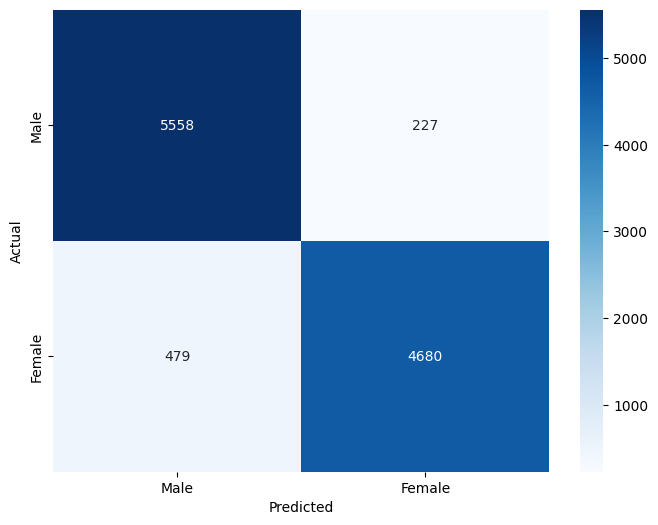

              precision    recall  f1-score   support

        Male       0.92      0.96      0.94      5785
      Female       0.95      0.91      0.93      5159

    accuracy                           0.94     10944
   macro avg       0.94      0.93      0.94     10944
weighted avg       0.94      0.94      0.94     10944



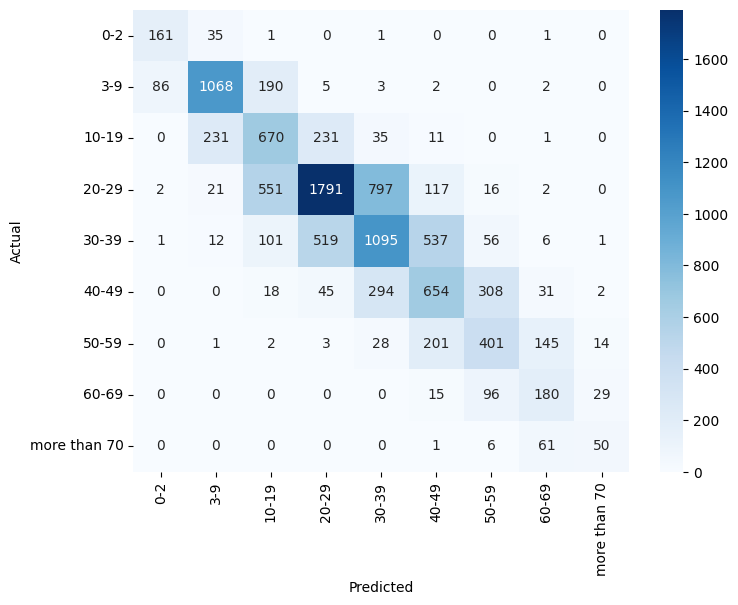

              precision    recall  f1-score   support

         0-2       0.64      0.81      0.72       199
         3-9       0.78      0.79      0.78      1356
       10-19       0.44      0.57      0.49      1179
       20-29       0.69      0.54      0.61      3297
       30-39       0.49      0.47      0.48      2328
       40-49       0.43      0.48      0.45      1352
       50-59       0.45      0.50      0.48       795
       60-69       0.42      0.56      0.48       320
more than 70       0.52      0.42      0.47       118

    accuracy                           0.55     10944
   macro avg       0.54      0.57      0.55     10944
weighted avg       0.57      0.55      0.56     10944



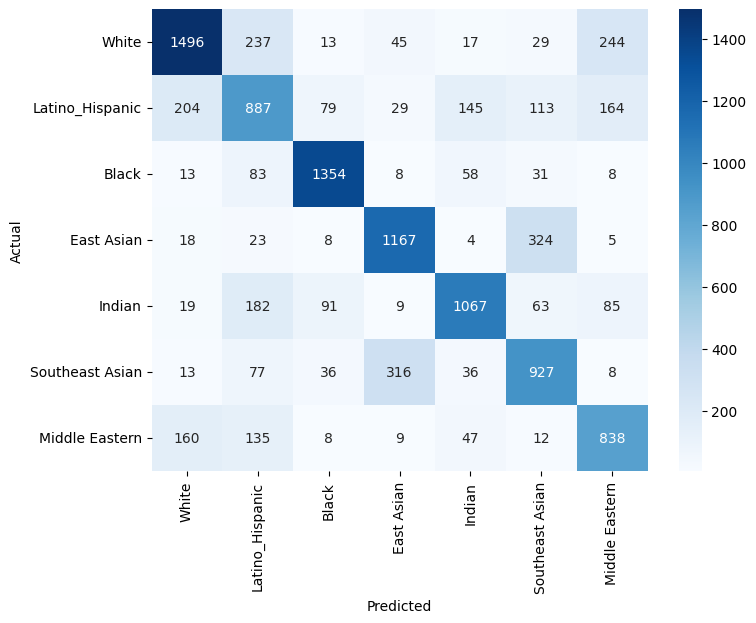

                 precision    recall  f1-score   support

          White       0.78      0.72      0.75      2081
Latino_Hispanic       0.55      0.55      0.55      1621
          Black       0.85      0.87      0.86      1555
     East Asian       0.74      0.75      0.75      1549
         Indian       0.78      0.70      0.74      1516
Southeast Asian       0.62      0.66      0.64      1413
 Middle Eastern       0.62      0.69      0.65      1209

       accuracy                           0.71     10944
      macro avg       0.70      0.71      0.70     10944
   weighted avg       0.71      0.71      0.71     10944



In [25]:
mlt_mm.conf_mat_class_report(train_dataset.classes, report=True, validation=True)

Forward pass took 14.75 ms
Class : Female with probability 98.05%
---------------
Class 1: 0-2 with probability 1.74%
Class 2: 3-9 with probability 90.37%
Class 3: 10-19 with probability 7.07%
Class 4: 20-29 with probability 0.56%
Class 5: 30-39 with probability 0.18%
Class 6: 40-49 with probability 0.05%
Class 7: 50-59 with probability 0.02%
Class 8: 60-69 with probability 0.01%
Class 9: more than 70 with probability 0.02%
----------------------
Class 1: White with probability 0.25%
Class 2: Latino_Hispanic with probability 4.11%
Class 3: Black with probability 0.09%
Class 4: East Asian with probability 10.45%
Class 5: Indian with probability 0.87%
Class 6: Southeast Asian with probability 84.22%
Class 7: Middle Eastern with probability 0.02%
Predictions:
gender:  Female age:  3-9 race:  Southeast Asian
True labels
Gender:  Female Age:  3-9 Race:  Southeast Asian


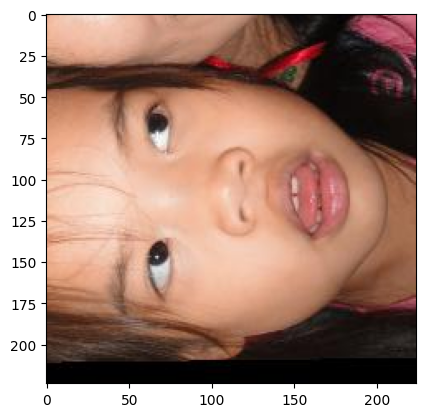

In [30]:
# torch.cuda.empty_cache()
idx = random.choice(range(len(val_dataset)))
img, (gen, age, race) = val_dataset[idx]
printNetResults(mlt_model, img, val_dataset.gender_classes, val_dataset.age_classes, val_dataset.race_classes)

print('True labels')
print('Gender: ', val_dataset.gender_classes[gen.int().item()], 
     'Age: ', val_dataset.age_classes[age],
     'Race: ', val_dataset.race_classes[race])

plt.imshow(img.squeeze(0).permute(2, 1, 0).detach().cpu().numpy())
plt.show()